In [1]:
# View catalog to e.g. manually delete poorly detected events
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date

##############
# Parameters #
years = [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
# years = [2013]


##############

catalog = []
for year in years:
    for event in os.listdir(f"Events_2stas/{year}_{year}Events_2stas"):
        catalog.append(
            pd.read_csv(
                f"Events_2stas/{year}_{year}events_2stas/{event}", sep="\t", index_col=0
            )
        )

In [2]:
# Load slip times based on second derivative
import datetime

min_stas = 2
ev_data = {"event": [], "trace_time": []}
df = pd.read_csv(f"./AllEventStartTimes_{min_stas}stas.txt", sep="\t")
ev_data["ev_time"] = df["EventStartTime"]

# Calculate time since last events
time_since_last_ev = [
    datetime.timedelta(seconds=1000000)
]  # Set large for first event because prior event time unknown
for i, event in enumerate(ev_data["ev_time"]):
    if i > 0:
        diff = datetime.datetime.strptime(
            ev_data["ev_time"][i], "%Y-%m-%d %H:%M:%S"
        ) - datetime.datetime.strptime(ev_data["ev_time"][i - 1], "%Y-%m-%d %H:%M:%S")
        time_since_last_ev.append(diff)
ev_data["time_since_last_ev"] = time_since_last_ev
print([(a.days * 24 * 3600 + a.seconds) / 3600 for a in ev_data["time_since_last_ev"]])

[277.77777777777777, 17.354166666666668, 21.766666666666666, 10.758333333333333, 13.254166666666666, 19.1125, 22.970833333333335, 10.4875, 11.895833333333334, 9.975, 14.345833333333333, 9.975, 14.845833333333333, 9.9875, 14.658333333333333, 12.0625, 13.1375, 9.808333333333334, 15.225, 10.9875, 14.591666666666667, 10.625, 15.1, 23.866666666666667, 8.416666666666666, 16.3375, 21.929166666666667, 10.666666666666666, 14.5875, 18.954166666666666, 14.941666666666666, 10.7375, 20.645833333333332, 13.025, 12.041666666666666, 11.0125, 13.125, 9.525, 15.145833333333334, 8.875, 15.625, 8.2875, 16.266666666666666, 8.525, 16.9125, 8.5125, 16.4875, 8.55, 19.804166666666667, 16.733333333333334, 11.6625, 12.2, 12.983333333333333, 13.9, 21.4, 20.2, 12.008333333333333, 11.979166666666666, 11.516666666666667, 12.891666666666667, 11.183333333333334, 13.1125, 11.1, 13.5125, 11.545833333333333, 13.420833333333333, 10.85, 14.083333333333334, 10.420833333333333, 14.325, 11.045833333333333, 16.941666666666666,

In [3]:
print(len(catalog))
print(len(ev_data["time_since_last_ev"]))

5030
5030


In [6]:
class SlipDist:
    def __init__(self, catalog, tsle_hr, evt_time, stas):
        self.catalog = catalog
        self.stas = []
        self.disps = []
        self.norm_disps = []
        self.tsle_hr = tsle_hr
        self.event_time = evt_time
        self.interevent_dists = []
        self.norm_interevent_dists = []
        for sta in stas:
            try:
                if catalog[f"{sta}x"].isna().sum() == 0:
                    self.stas.append(sta)
            except KeyError:
                pass

    def get_disps(self):
        for sta in self.stas:
            disp = self.catalog[f"{sta}x"].iloc[-1] - self.catalog[f"{sta}x"].iloc[0]
            self.disps.append(disp)
            self.norm_disps.append(disp)

    def get_interevent_dists(self, slipdist):
        for sta in self.stas:
            if sta in slipdist.stas:
                dist = (
                    self.catalog[f"{sta}x"].iloc[0]
                    - slipdist.catalog[f"{sta}x"].iloc[-1]
                )
                self.interevent_dists.append(dist)
                self.norm_interevent_dists.append(dist)
            else:
                self.interevent_dists.append(np.nan)
                self.norm_interevent_dists.append(np.nan)

In [8]:
import numpy as np

stas = [
    "la01",
    "la02",
    "la03",
    "la04",
    "la05",
    "la06",
    "la07",
    "la08",
    "la09",
    "la10",
    "la11",
    "la12",
    "la13",
    "la14",
    "la15",
    "la16",
    "la17",
    "la18",
    "ws04",
    "ws05",
    "gz01",
    "gz02",
    "gz03",
    "gz04",
    "gz05",
    "gz06",
    "gz07",
    "gz08",
    "gz09",
    "gz10",
    "gz11",
    "gz12",
    "gz13",
    "gz14",
    "gz15",
    "gz16",
    "gz17",
    "gz18",
    "gz19",
    "gz20",
    "mg01",
    "mg02",
    "mg03",
    "mg04",
    "mg05",
    "mg06",
    "mg07",
    "slw1",
]
tsle_hr = [
    (a.days * 24 * 3600 + a.seconds) / 3600 for a in ev_data["time_since_last_ev"]
]

slip_dists = []
for cat, tsle, ev_time in zip(catalog, tsle_hr, ev_data["ev_time"]):
    slip_dist = SlipDist(cat, tsle, ev_time, stas)
    slip_dist.get_disps()
    slip_dists.append(slip_dist)

for i, slip_dist in enumerate(slip_dists):
    if i > 0:
        slip_dist.get_interevent_dists(slip_dists[i - 1])
    # Append nans equal to len of sta for 1st even
slip_dists[0].interevent_dists.append(np.nan)
slip_dists[0].interevent_dists.append(np.nan)
slip_dists[0].norm_interevent_dists.append(np.nan)
slip_dists[0].norm_interevent_dists.append(np.nan)

/tmp/ipykernel_5888/513579773.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


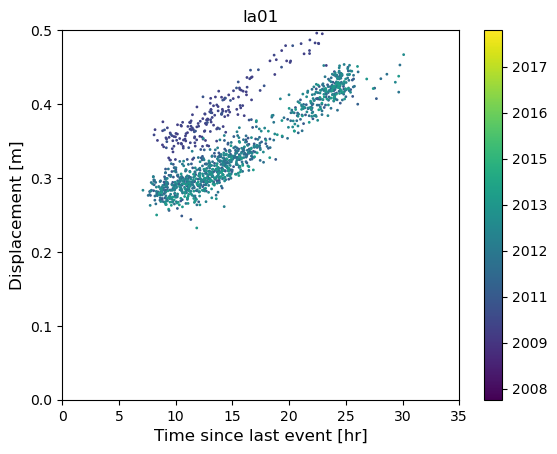

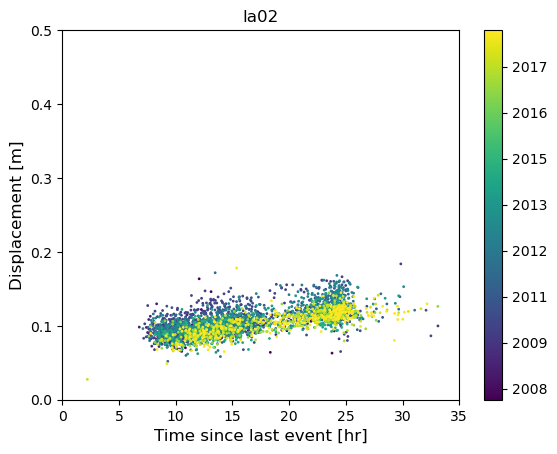

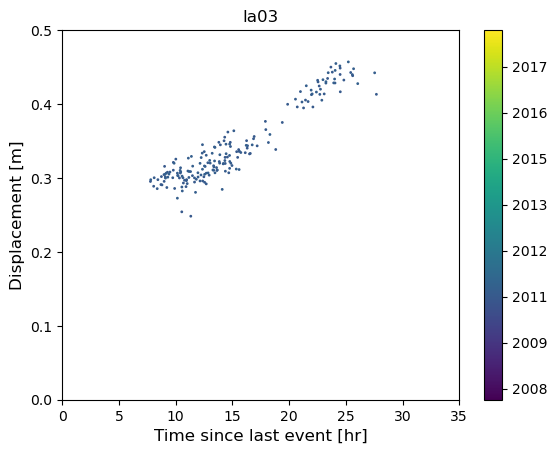

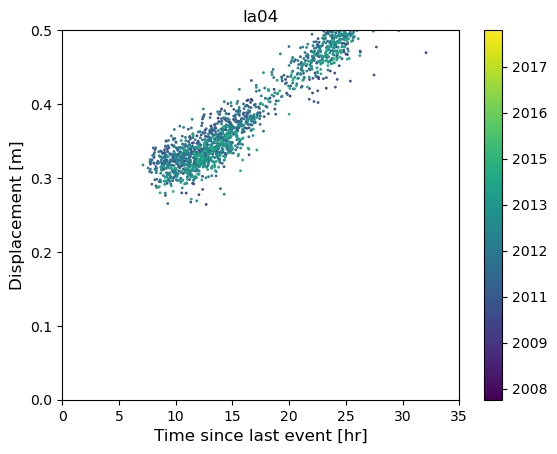

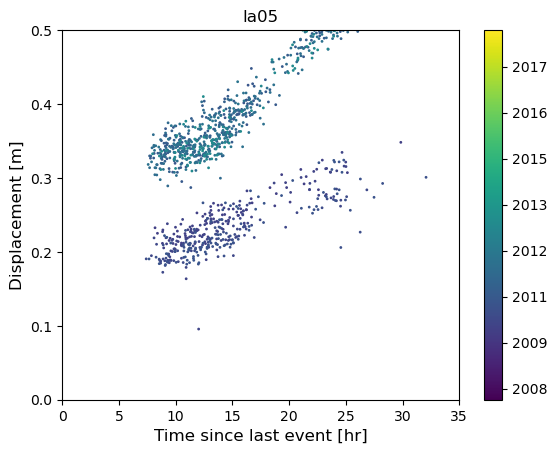

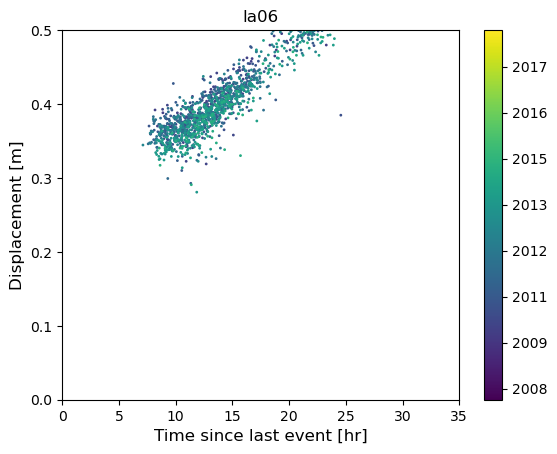

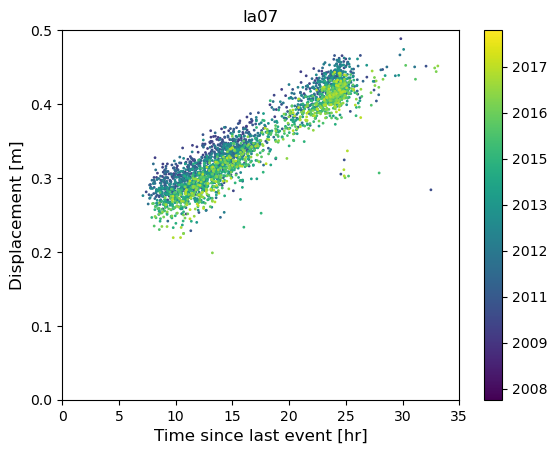

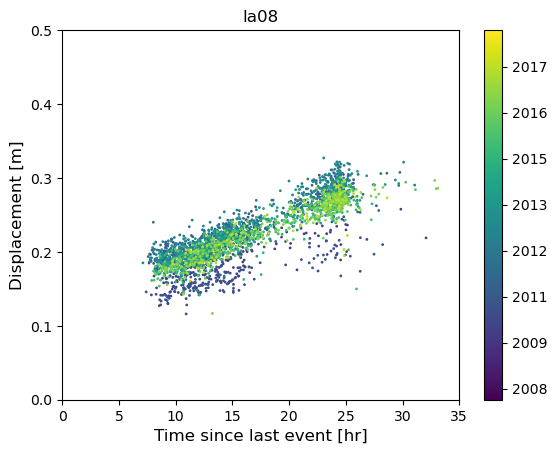

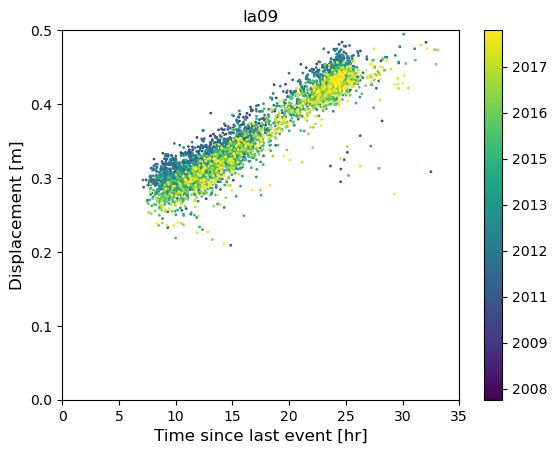

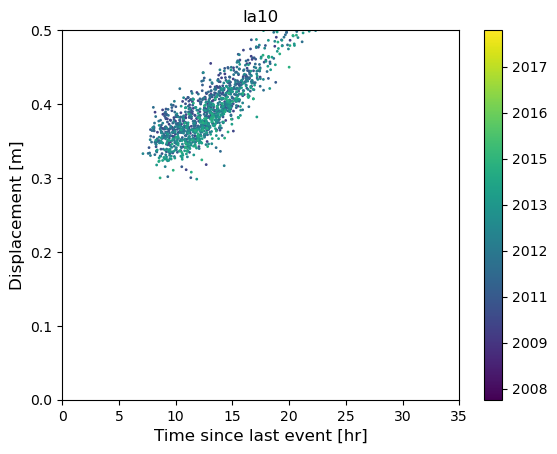

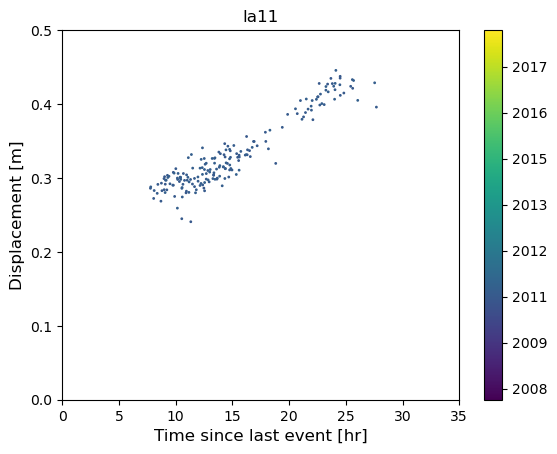

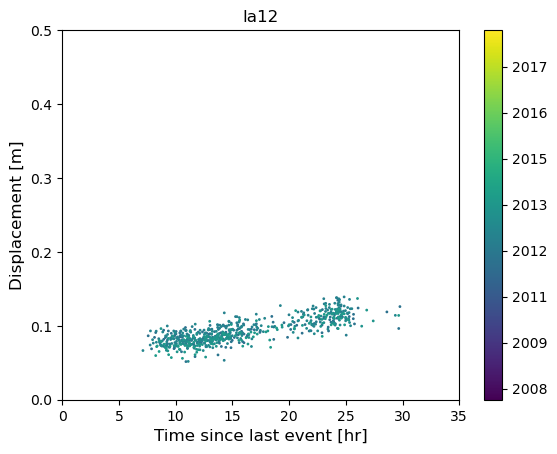

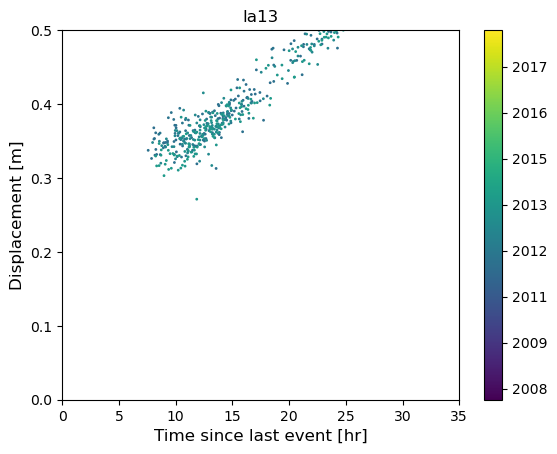

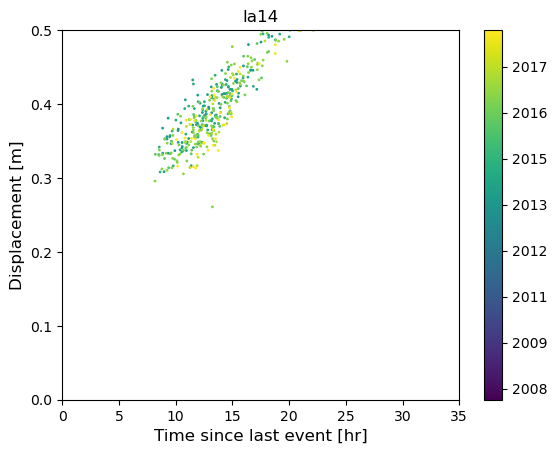

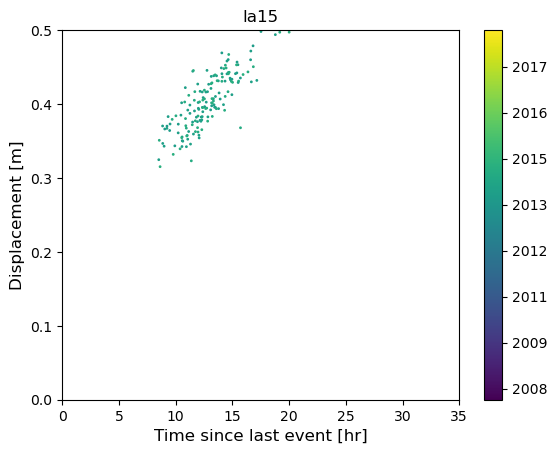

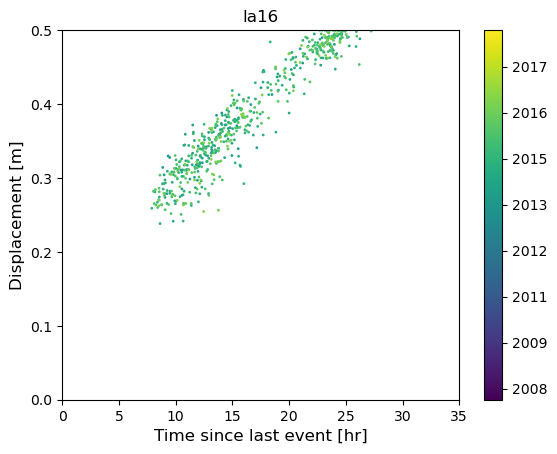

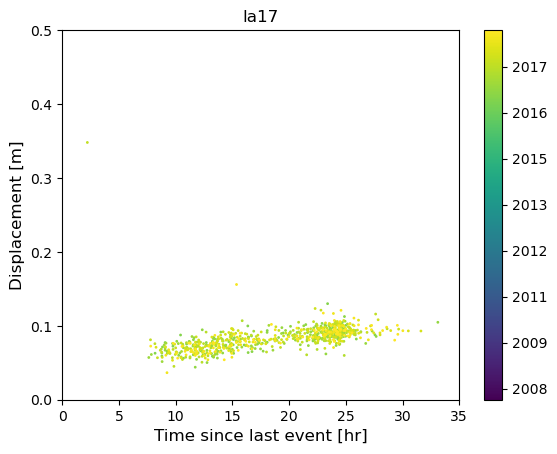

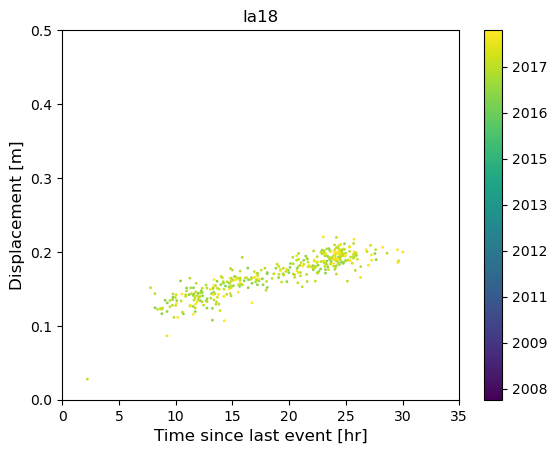

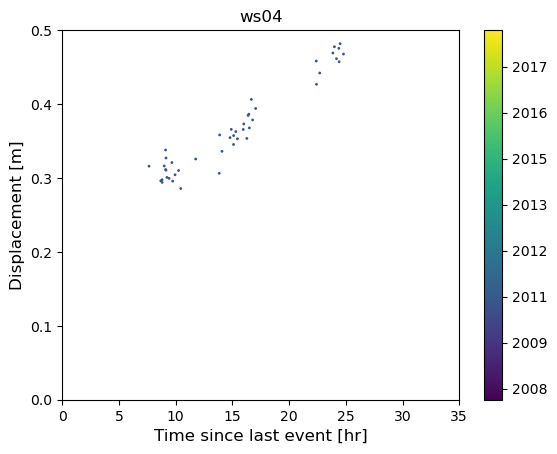

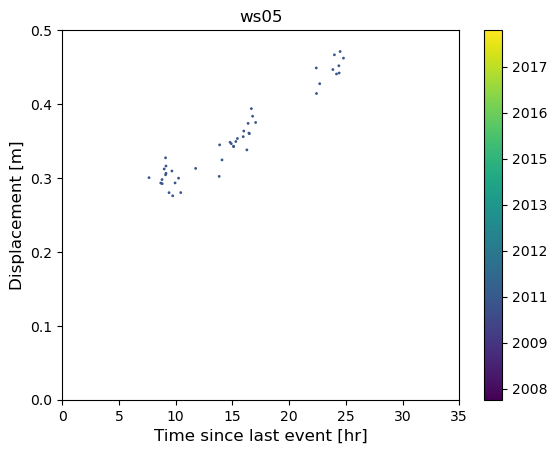

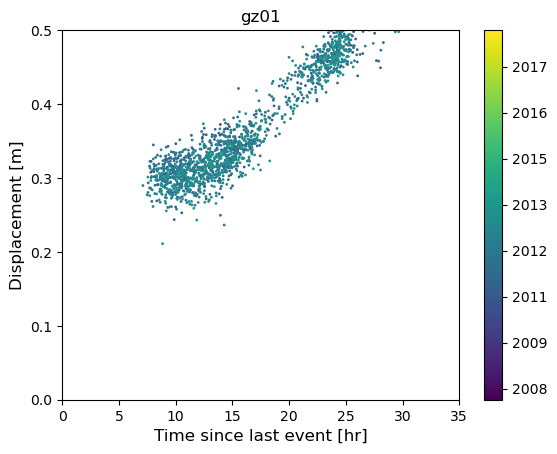

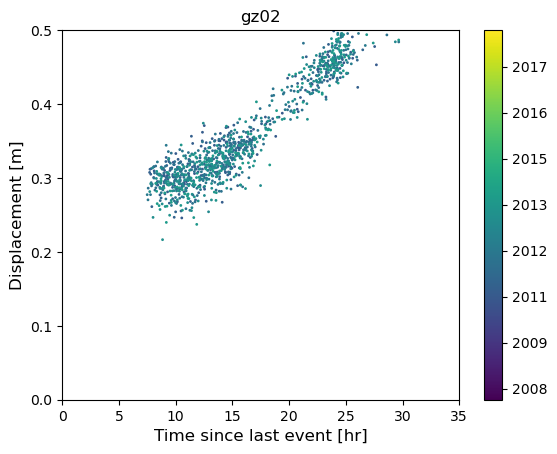

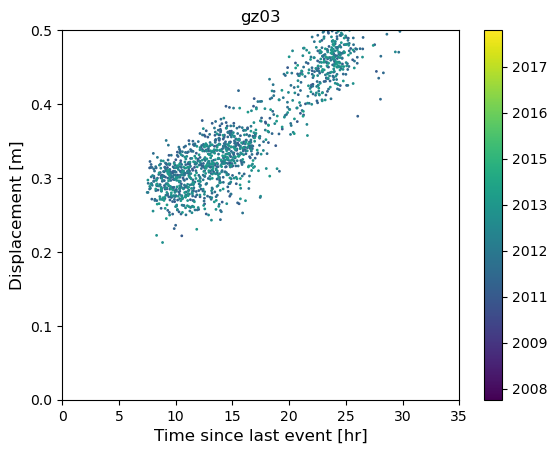

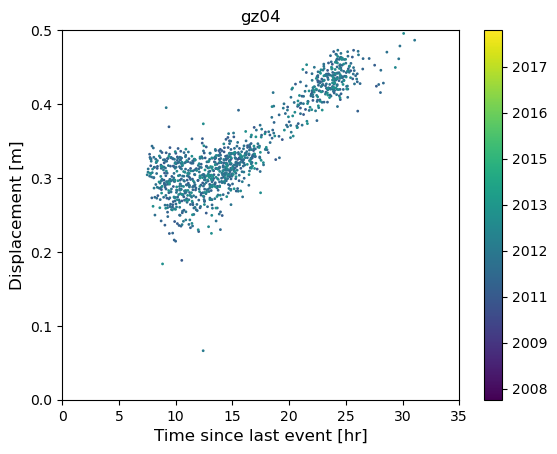

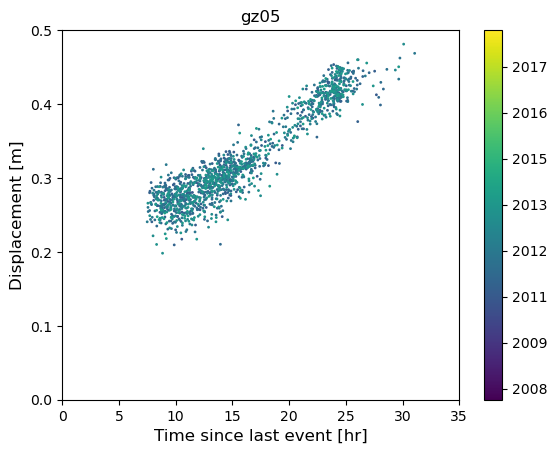

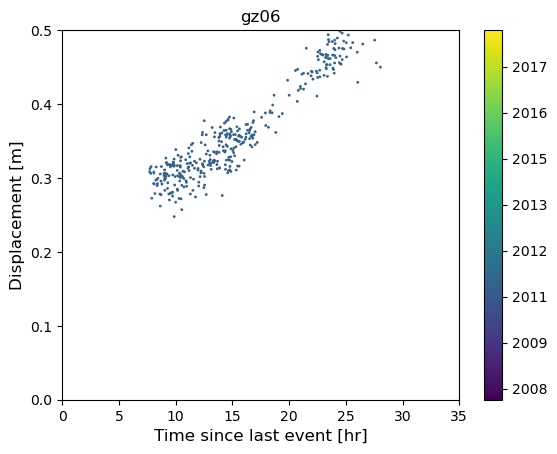

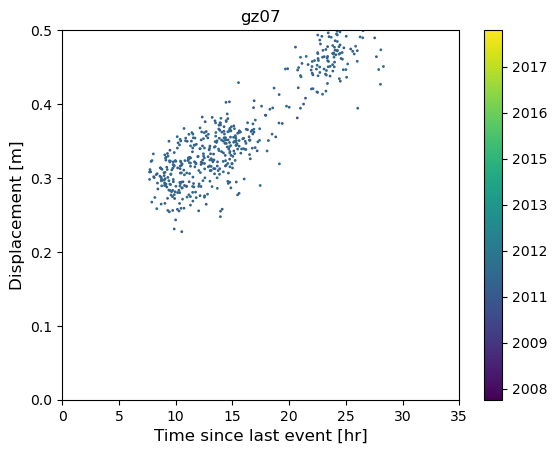

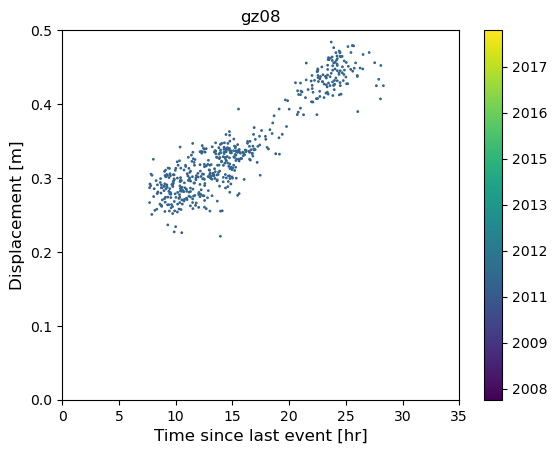

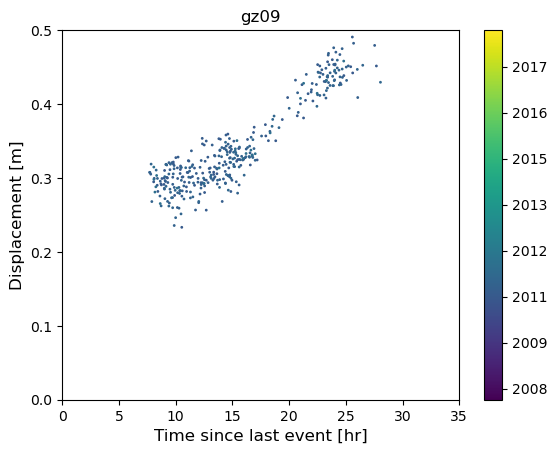

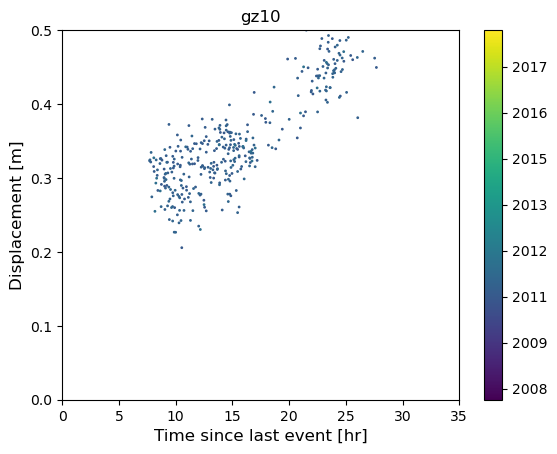

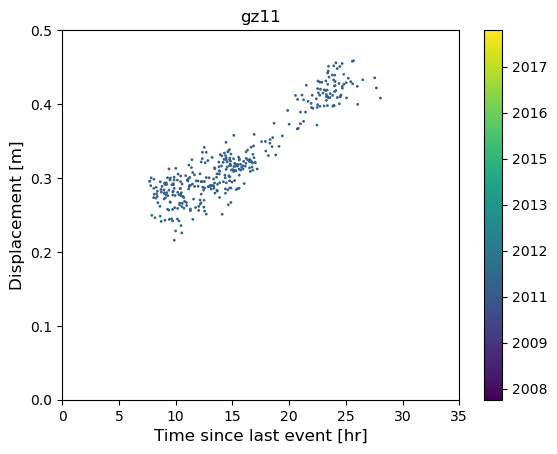

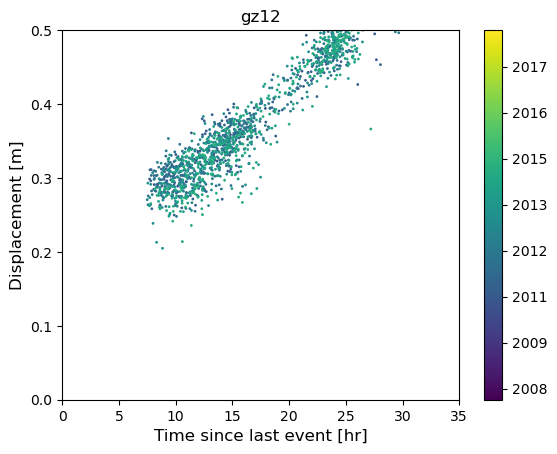

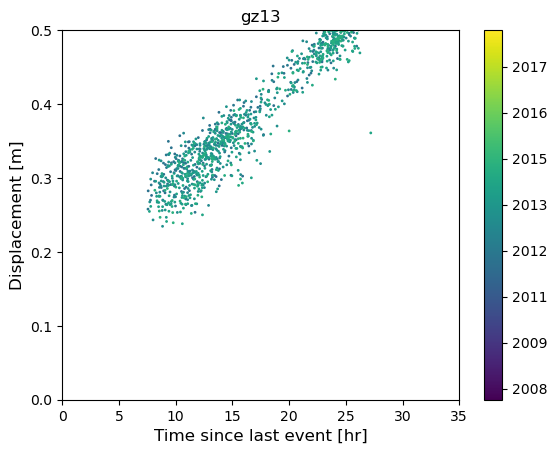

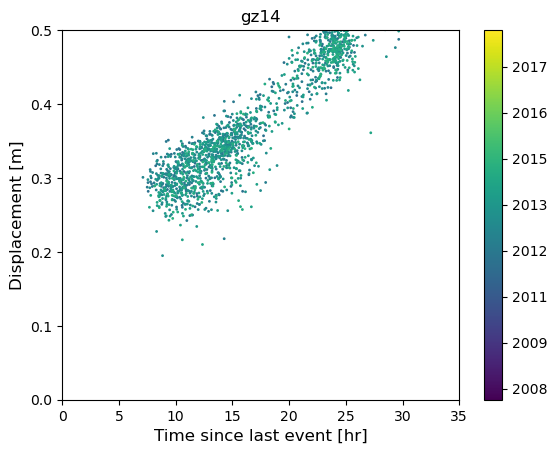

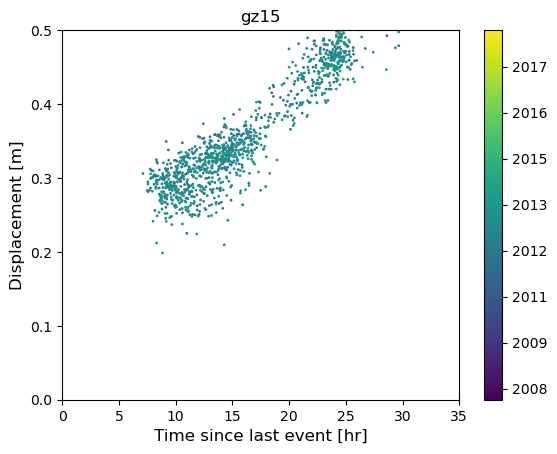

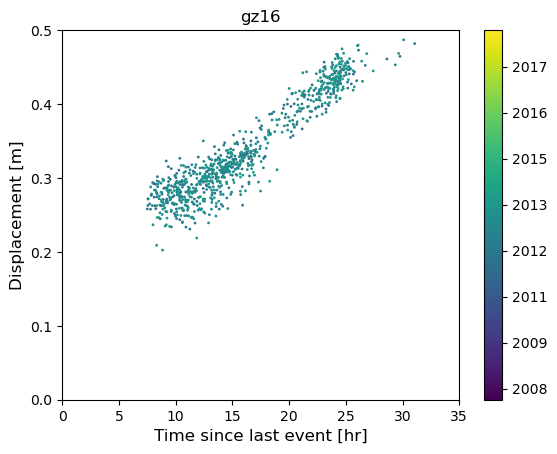

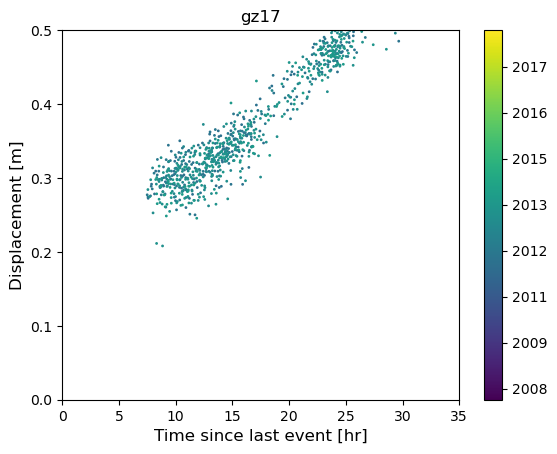

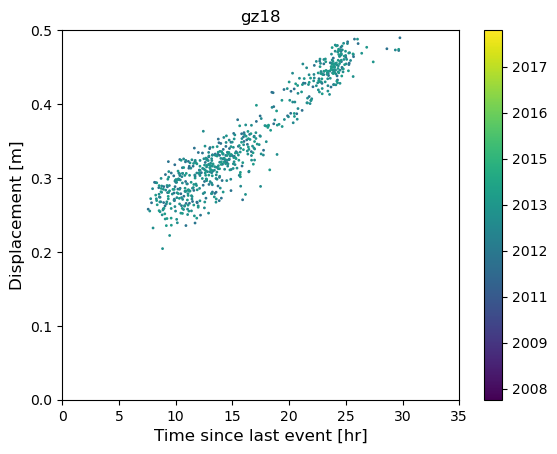

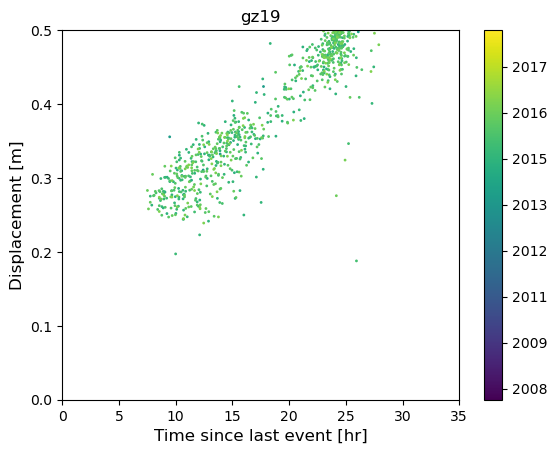

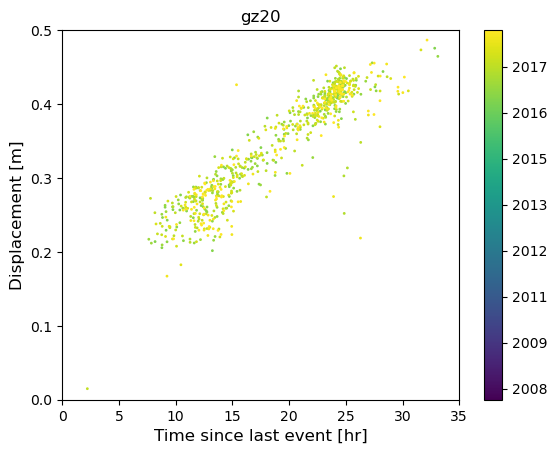

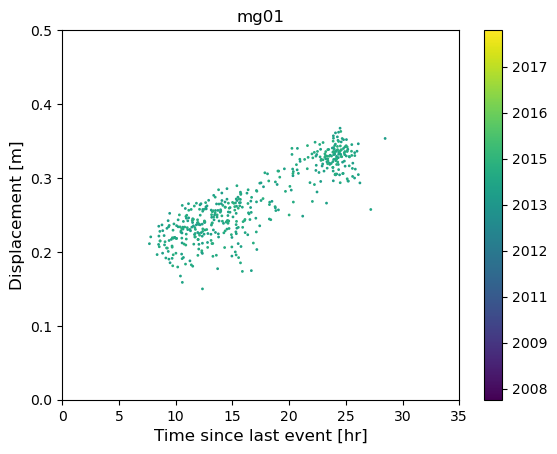

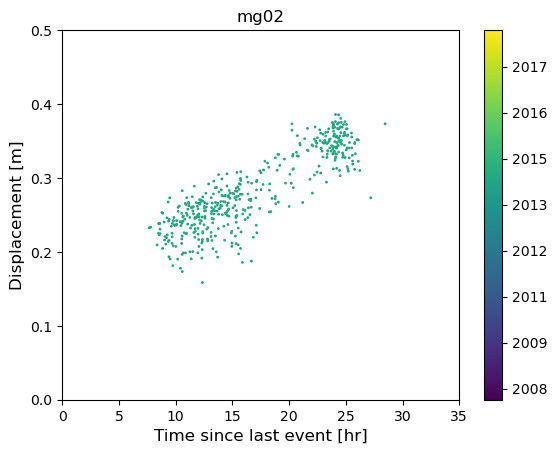

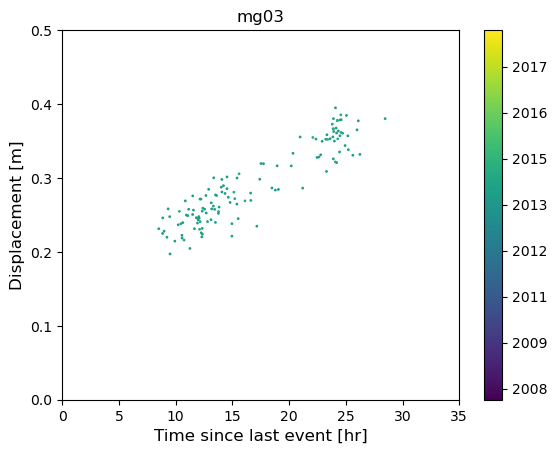

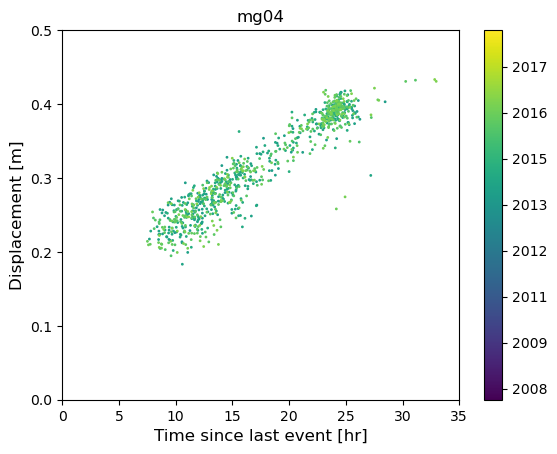

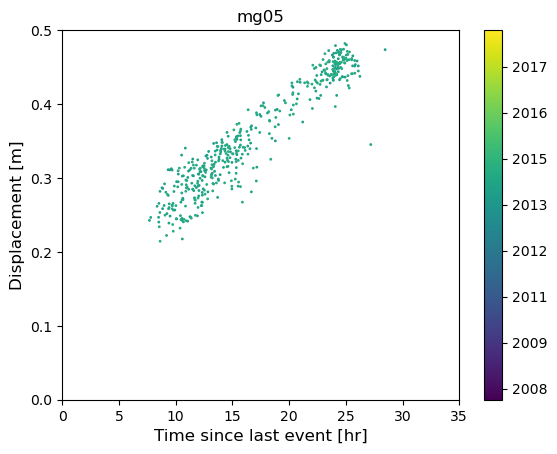

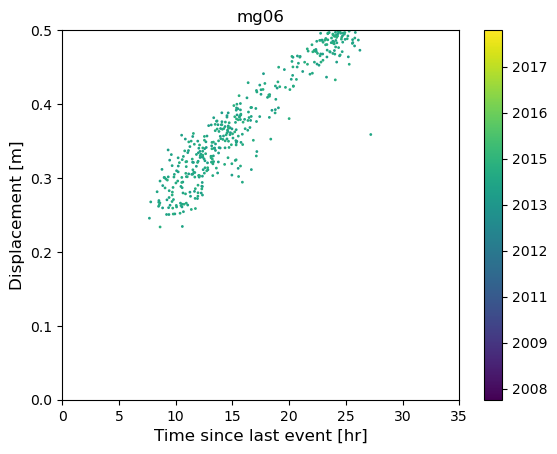

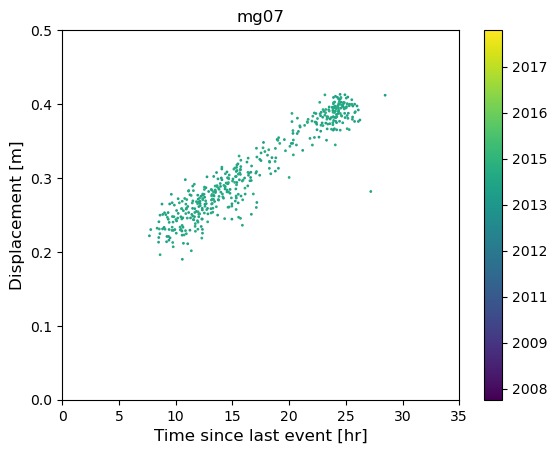

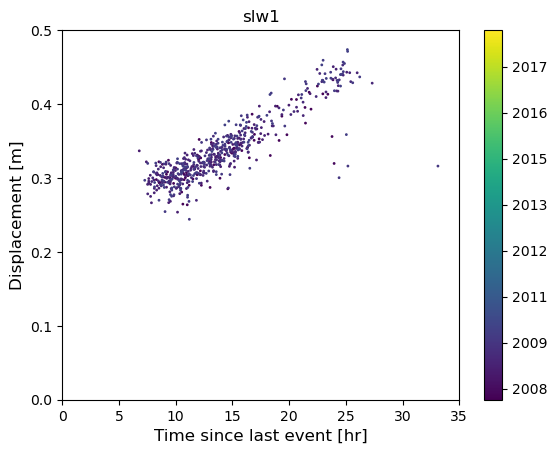

In [ ]:
for sta in stas[:]:
    # Get slip distance of that station for each event
    disps = [
        slip_dist.disps[slip_dist.stas.index(sta)]
        for slip_dist in slip_dists
        if sta in slip_dist.stas
    ]
    tsle = [slip_dist.tsle_hr for slip_dist in slip_dists if sta in slip_dist.stas]
    cat_time_parsed = [
        datetime.datetime.strptime(slip_dist.event_time, "%Y-%m-%d %H:%M:%S")
        for slip_dist in slip_dists
        if sta in slip_dist.stas
    ]
    fig, ax = plt.subplots()
    cbar = ax.scatter(
        tsle,
        disps,
        c=[date2num(i) for i in cat_time_parsed],
        cmap="viridis",
        s=1,
        vmin=date2num(datetime.datetime(2008, 1, 1)),
        vmax=date2num(datetime.datetime(2019, 1, 1)),
    )
    ax.set_xlabel("Time since last event [hr]", fontsize=12)
    ax.set_ylabel("Displacement [m]", fontsize=12)

    def format_colorbar_ticks(x, pos):
        """Convert numerical date back to readable format."""
        return num2date(x).strftime("%Y")

    cbar = fig.colorbar(cbar)
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(format_colorbar_ticks))
    ax.set_xlim([0, 35])
    ax.set_ylim([0.0, 0.5])
    ax.set_title(sta)

Text(0.5, 1.0, 'la09 vs la08')

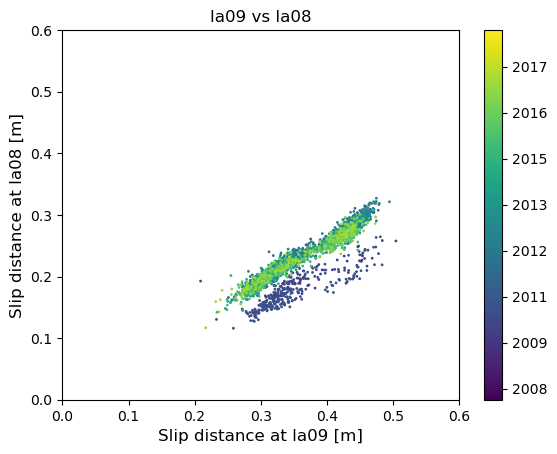

In [ ]:
# Cull events with both sta1 and sta2
sta1 = "la09"
sta2 = "la08"
culled_slip_dists = []
for slip_dist in slip_dists:
    if sta1 in slip_dist.stas and sta2 in slip_dist.stas:
        culled_slip_dists.append(slip_dist)

disps1 = [
    slip_dist.disps[slip_dist.stas.index(sta1)] for slip_dist in culled_slip_dists
]
disps2 = [
    slip_dist.disps[slip_dist.stas.index(sta2)] for slip_dist in culled_slip_dists
]
tsle = [slip_dist.tsle_hr for slip_dist in culled_slip_dists]
cat_time_parsed = [
    datetime.datetime.strptime(slip_dist.event_time, "%Y-%m-%d %H:%M:%S")
    for slip_dist in culled_slip_dists
]

fig, ax = plt.subplots()
cbar = ax.scatter(
    disps1,
    disps2,
    c=[date2num(i) for i in cat_time_parsed],
    cmap="viridis",
    s=1,
    vmin=date2num(datetime.datetime(2008, 1, 1)),
    vmax=date2num(datetime.datetime(2019, 1, 1)),
)
ax.set_xlabel(f"Slip distance at {sta1} [m]", fontsize=12)
ax.set_ylabel(f"Slip distance at {sta2} [m]", fontsize=12)


def format_colorbar_ticks(x, pos):
    """Convert numerical date back to readable format."""
    return num2date(x).strftime("%Y")


cbar = fig.colorbar(cbar)
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(format_colorbar_ticks))
ax.set_xlim([0, 0.6])
ax.set_ylim([0.0, 0.6])
ax.set_title(f"{sta1} vs {sta2}")

3938


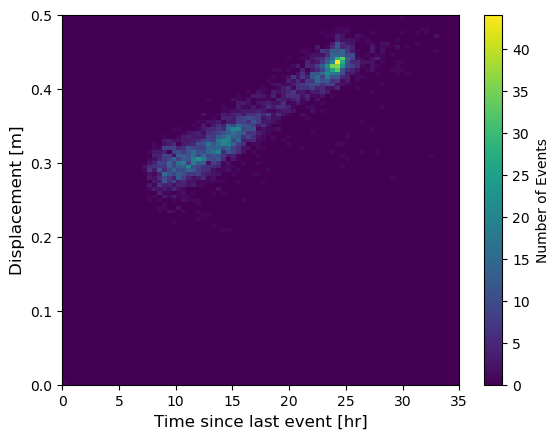

In [142]:
sta = "la09"
culled_slip_dists = []
for slip_dist in slip_dists:
    if sta in slip_dist.stas:
        culled_slip_dists.append(slip_dist)


disps = [slip_dist.disps[slip_dist.stas.index(sta)] for slip_dist in culled_slip_dists]
tsles = [slip_dist.tsle_hr for slip_dist in culled_slip_dists]
# Remove events over 35 hrs
zipped = [(tsle, disp) for tsle, disp in zip(tsles, disps) if tsle < 35]
tsles = [i[0] for i in zipped]
disps = [i[1] for i in zipped]
tsles.append(0)
disps.append(0)
tsles.append(35)
disps.append(0.5)

fig, ax = plt.subplots()
col = ax.hist2d(tsles, disps, bins=(80, 100), cmap="viridis")
ax.set_xlabel("Time since last event [hr]", fontsize=12)
ax.set_ylabel("Displacement [m]", fontsize=12)
cbar = plt.colorbar(col[3], ax=ax, label="Number of Events")
ax.set_xlim([0, 35])
ax.set_ylim([0.0, 0.5])
# ax.plot([0,35],[0,0.5],color='red')
print(len(disps))

1.1574074074074074e-10
3.8580246913580245e-11


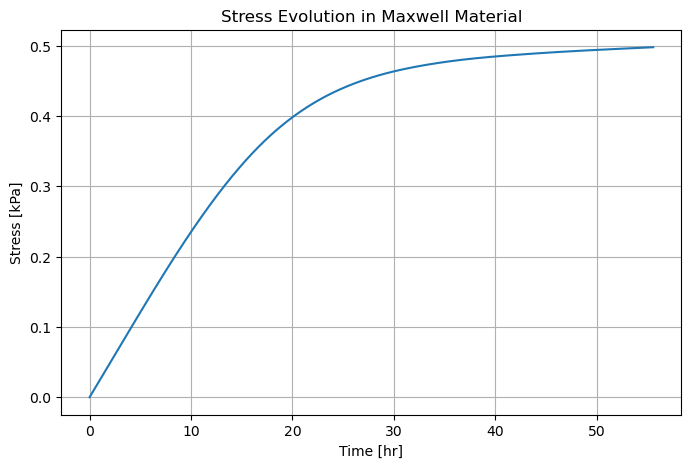

In [144]:
# TEST OF STRAIN RATe
# With help of ChatGPT
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters
E = 10e9  # Elastic modulus (Pa)
eta = 1e14  # Viscosity (Pa*s)
A = 2.1e-25  # Glens flow law parameter (Pa^-3 s^-1)
strain_rate = 1 / (3600 * 24) / 100e3  # Constant strain rate (arbitrary units)
print(strain_rate)
k = E * A  # Parameter for nonlinear term
sigma0 = 0.0  # Initial stress


# Differential equation: dsigma/dt = E * strain_rate - (E/eta) * sigma^3
def maxwell_model(t, sigma):
    C = E * strain_rate  # Constant term from strain rate
    return C - k * sigma * sigma * sigma


# Time range for the integration
t_span = (0, 20e4)  # From t=0 to t=10
t_eval = np.linspace(t_span[0], t_span[1], 1500)  # Points to evaluate

# Initial condition
y0 = [sigma0]

# Solve the differential equation
solution = solve_ivp(maxwell_model, t_span, y0, t_eval=t_eval, method="RK45")

# Extract results
t = solution.t
sigma = solution.y[0]

# Repeat downstream
# Parameters
E = 1e9  # Elastic modulus (Pa)
eta = 1e14  # Viscosity (Pa*s)
A = 2.1e-25  # Glens flow law parameter (Pa^-3 s^-1)
strain_rate = 0.2 / (3600 * 24) / 60e3  # Constant strain rate (arbitrary units)
print(strain_rate)
k = E * A  # Parameter for nonlinear term
sigma0 = 0.0  # Initial stress


# Differential equation: dsigma/dt = E * strain_rate - (E/eta) * sigma^3
def maxwell_model(t, sigma):
    C = E * strain_rate  # Constant term from strain rate
    return C - k * sigma * sigma * sigma


# Time range for the integration
t_span = (0, 20e4)  # From t=0 to t=10
t_eval = np.linspace(t_span[0], t_span[1], 1500)  # Points to evaluate

# Initial condition
y0 = [sigma0]

# Solve the differential equation
solution = solve_ivp(maxwell_model, t_span, y0, t_eval=t_eval, method="RK45")

# Extract results
t = solution.t
sigmaddown = solution.y[0]

mu = E / (2 * (1 + 0.3))
r = 75e3

# Net sigma
sigma = (sigma * 1000 + sigmaddown * 750) / 25e3
dist = 16 * r * sigma / (7 * np.pi * mu)
# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(t / 3600, dist, label="Stress $\sigma(t)$")
plt.title("Stress Evolution in Maxwell Material")
plt.xlabel("Time [hr]")
plt.ylabel("Stress [kPa]")
plt.grid()
plt.show()

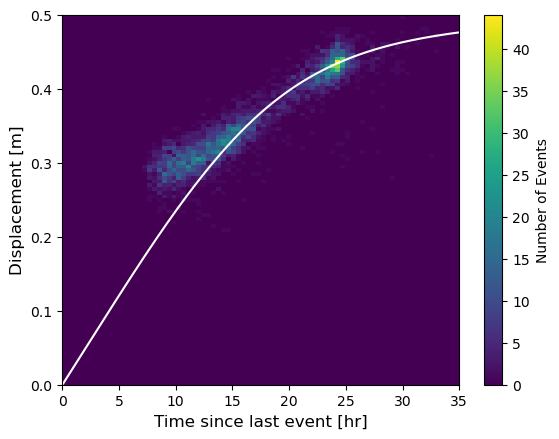

In [141]:
sta = "la09"
culled_slip_dists = []
for slip_dist in slip_dists:
    if sta in slip_dist.stas:
        culled_slip_dists.append(slip_dist)


disps = [slip_dist.disps[slip_dist.stas.index(sta)] for slip_dist in culled_slip_dists]
tsles = [slip_dist.tsle_hr for slip_dist in culled_slip_dists]
# Remove events over 35 hrs
zipped = [(tsle, disp) for tsle, disp in zip(tsles, disps) if tsle < 35]
tsles = [i[0] for i in zipped]
disps = [i[1] for i in zipped]
tsles.append(0)
disps.append(0)
tsles.append(35)
disps.append(0.5)

fig, ax = plt.subplots()
col = ax.hist2d(tsles, disps, bins=(80, 100), cmap="viridis")
ax.set_xlabel("Time since last event [hr]", fontsize=12)
ax.set_ylabel("Displacement [m]", fontsize=12)
cbar = plt.colorbar(col[3], ax=ax, label="Number of Events")
ax.set_xlim([0, 35])
ax.set_ylim([0.0, 0.5])

ax.plot(t / 3600, dist, color="white")